In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
sns.set()

from scipy.stats import norm, uniform
import random

### 데이터셋 준비

In [2]:
# 다섯 종복에 대한 데이터
tickers = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'NFLX']

stocks = yf.Tickers(tickers)

data = stocks.history(start='2000-01-01', actions=False)

data.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)

data = data.droplevel(0, axis=1)

[*********************100%***********************]  5 of 5 completed


<Axes: xlabel='Date'>

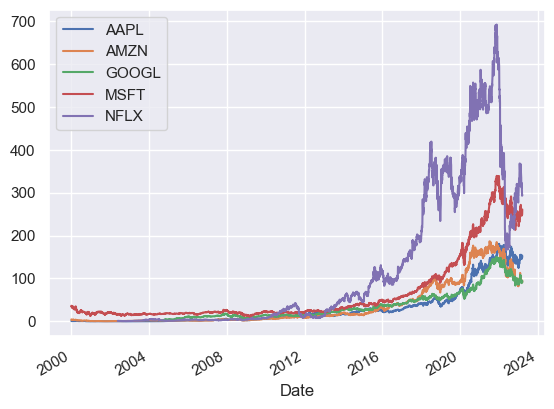

In [3]:
data.plot()

<Axes: xlabel='Date'>

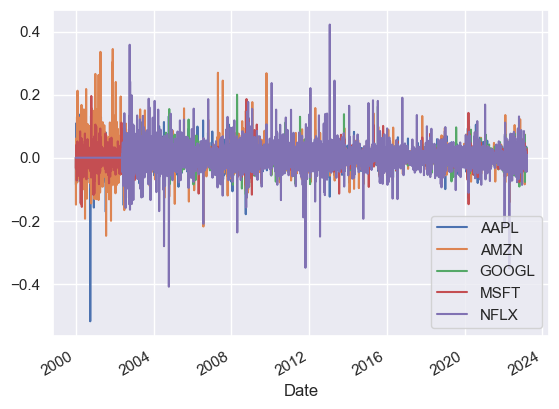

In [4]:
rets = data.pct_change().fillna(0)
rets.plot()

### 단일 자산에 대한 몬테카를로 시뮬레이션 VaR, CVaR

In [5]:
# T 시점 후의 가격 계산 함수
def terminal_price(S_0, mu, sigma, Z, T):
    # Z 임의의 난수 값
    # T 시간 1이면 1년
    # return 기하 브라운운동
    return S_0 * np.exp((mu - sigma ** 2 / 2) * T + sigma * np.sqrt(T) * Z)

In [6]:
# 애플 주가 데이터
aapl = data['AAPL']

# 애플 수익률
aapl_rets = aapl.pct_change().dropna()

# 애플 평균 수익률
mu = aapl_rets.mean() * 252

# 애플 표준 편차
sigma = aapl_rets.std() * np.sqrt(252)

# 시뮬레이션 기간 (3개월)
T = 0.25

# 시뮬레이션 횟수
n_simulations = 10000

# VaR %
delta = 0.01

# 현재 주가
S_0 = aapl.iloc[-1]

In [7]:
# 난수 생성
# norm.rvs : random variable simulation (자산 개수, 시뮬레이션 횟수)
Z = norm.rvs(size=[1, n_simulations])

# 주가 미래 가격에 대한 시뮬레이션
# mu : 평규 수익률 0으로 가정
# numpy.array로 반환되기 때문에 pandas.Series로 반환
## flatten() --> [[]] -> []로 변환 
S_T = pd.Series(terminal_price(S_0, 0, sigma, Z, T).flatten())

# 포트폴리오 수익률 계산
## 10000개의 시뮬레이션 수익률 Series
aapl_return = (S_T - S_0) / S_0

In [8]:
# VaR
aapl_VaR = aapl_return.quantile(delta)

# CVaR
aapl_CVaR = aapl_return[aapl_return <= aapl_VaR].mean()

In [9]:
print('AAPL VaR = {}'.format(np.round(aapl_VaR * 100, 2)))
print('AAPL CVaR = {}'.format(np.round(aapl_CVaR * 100, 2)))

AAPL VaR = -37.93
AAPL CVaR = -41.9


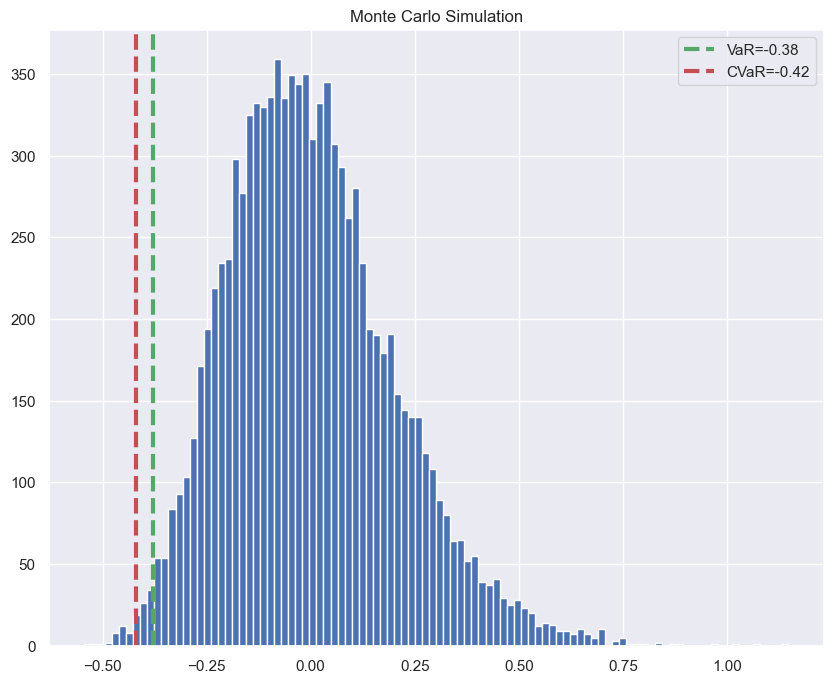

In [10]:
# VaR, CVaR 그래프
plt.figure(figsize=(10, 8))
plt.hist(aapl_return, bins=100)
plt.title('Monte Carlo Simulation')
plt.axvline(aapl_VaR, color='g', linewidth=3, linestyle='dashed', label='VaR={}'.format(np.round(aapl_VaR, 2)))
plt.axvline(aapl_CVaR, color='r', linewidth=3, linestyle='dashed', label='CVaR={}'.format(np.round(aapl_CVaR, 2)))
plt.legend()

### 시뮬레이션을 위한 초기 패러미터값 설정

In [11]:
# Parameters

# 초기 추가
S_0 = data.iloc[-1]

# 수익률
mu = rets.mean() * 252

# 변동성
sigma = rets.std() * np.sqrt(252)

# 상관계수 행렬
## 난수를 생성할 때 난수들의 상관계수 반영이 필요
corr = rets.corr()

# 촐레스키 분해
## 자산간의 상관성이 존재한다면 난수 생성시 상관성 반영 도구
L = np.linalg.cholesky(corr)

# 시뮬레이션 기간 (1년)
T = 1

### 촐레스키 분해

$$ A=LL^T$$

<b>촐레스키 분해</b>

어떤 주어진 행렬을 위삼각행렬과 아랫삼각행렬로 분해하는 기법.

위삼각행렬과 아랫삼각행렬을 서로 대칭적임

<b>촐레스키 분해를 사용하는 이유</b>

몬테카를로 시뮬레이션을 실행할 때 주가간의 존재하는 상관관계를 반영하여 주가의 미래 경로를 생성하기 위함.

즉, 서로 상관관계가 존재하는 난수를 생성할 수 있게 해주는 도구가 바로 촐레스키 분해임


### 몬테카를로 시뮬레이션 VaR

In [12]:
# 난수 생성 시드 = 0
np.random.seed(0)

# 시뮬레이션 횟수
n_simulations = 10000

# VaR % 
delta = 0.01

# 현재 포트폴리오 가치
portval_current = np.sum(S_0)
print(portval_current)

897.1700057983398


### 기하 브라운 운동 : 자산 가격 다이나믹스

$$ S_T=S_0e^{(r-\frac{\sigma^2}{2})\times T + \sigma\sqrt{T}Z}$$

- $S_T$ : $T$ 시점 이후 주가

- $S_0$ : 현재 주가

- $r$ : 무위험수익률

- $\sigma$ : 주가 변동성

- $T$ : 전체 기간

- $Z$ : 정규분포로부터 나온 난수

In [13]:
# T 시점 후의 가격 계산 함수
def terminal_price(S_0, mu, sigma, Z, T):
    return S_0 * np.exp((mu - sigma ** 2 / 2) * T + sigma * np.sqrt(T) * Z)

In [14]:
# 자산간 상관계수를 고려한 난수 생성
## 촐레스키 분해 행렬과 난수(random variable simulation)를 곱함
Z = np.matmul(L, norm.rvs(size=[len(data.columns), n_simulations]))

# 주가 미래 가격에 대한 시뮬레이션
price_future = terminal_price(np.array(S_0).reshape(len(S_0), 1), 0, np.array(sigma).reshape(len(sigma), 1), Z, T)

In [15]:
# 포트폴리오 시뮬레이션
portval_future = np.sum(price_future, axis=0)

# 포트폴리오 수익률 계산
port_return = (portval_future - portval_current) / portval_current

In [16]:
type(port_return)

numpy.ndarray

In [17]:
port_return

array([ 0.09582283,  0.048     ,  0.93274304, ...,  0.02294355,
       -0.01705344, -0.03692778])

### 몬테카를로 시뮬레이션 VaR과 CVaR 계산

In [18]:
# 포트폴리오 VaR
# array이므로 pd.DataFrame으로 전환
port_VaR = pd.Series(port_return).quantile(delta)

# 포트폴리오 CVaR
port_CVaR = np.mean(port_return[port_return <= port_VaR])

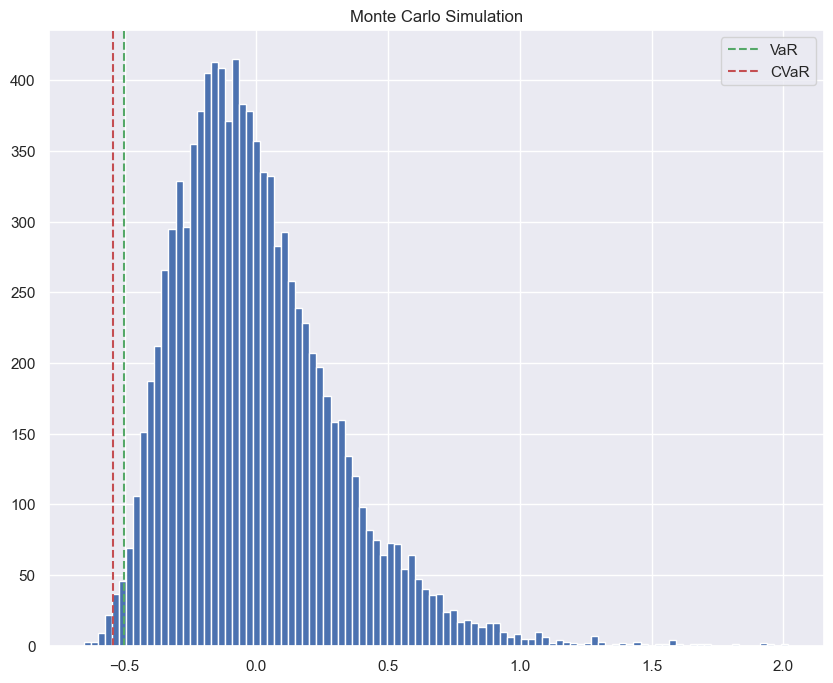

In [19]:
# VaR, CVaR 그래프
plt.figure(figsize=(10, 8))
plt.hist(port_return, bins=100)
plt.title('Monte Carlo Simulation')
plt.axvline(port_VaR, color='g', linestyle='dashed', label='VaR')
plt.axvline(port_CVaR, color='r', linestyle='dashed', label='CVaR')
plt.legend()